In [1]:
import random
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

## Enable TF eager mode

In [2]:
tf.enable_eager_execution()

## Settings

In [3]:
NUM_EPOCHS = 4 # ADJUST
BATCH_SIZE = 64 # ADJUST
LEARNING_RATE = 0.0001 # ADJUST

## Load and preprocess MNIST dataset

In [4]:
train_data, test_data = tf.keras.datasets.mnist.load_data()
train_images, train_labels = train_data
test_images, test_labels = test_data

train_images = train_images.reshape(-1, 28, 28, 1).astype(np.float32)/255
test_images = test_images.reshape(-1, 28, 28, 1).astype(np.float32)/255

train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)

print('Train images shape: {}'.format(train_images.shape))
print('Test images shape: {}'.format(test_images.shape))

Train images shape: (60000, 28, 28, 1)
Test images shape: (10000, 28, 28, 1)


## Visualize MNIST examples

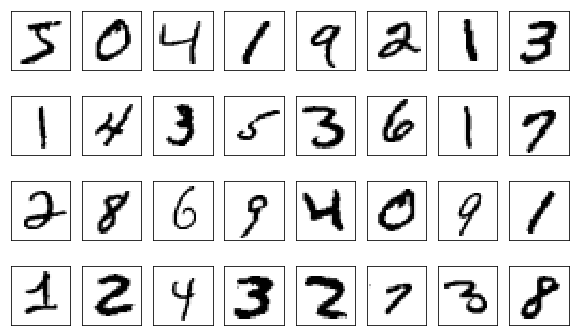

In [5]:
some_samples = train_images[:32, ...]

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j,:,:,0], cmap='binary')
    plt.xticks(np.array([])), plt.yticks(np.array([]))
plt.show()

## Create TF data pipeline

In [6]:
num_examples = train_images.shape[0]

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(buffer_size=num_examples)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

## Create NN model class

In [7]:
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()

        self.conv1 = tf.layers.Conv2D(32, (5, 5), activation=tf.nn.relu,
            padding='same',
            bias_initializer=tf.constant_initializer(0.1),
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))
        
        self.conv2 = tf.layers.Conv2D(64, (5, 5), activation=tf.nn.relu,
            padding='same',
            bias_initializer=tf.constant_initializer(0.1),
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))
        
        self.fc1 = tf.layers.Dense(256, activation=tf.nn.relu,
            bias_initializer=tf.constant_initializer(0.1),
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))
        
        self.fc2 = tf.layers.Dense(10, activation=None,
            bias_initializer=tf.constant_initializer(0.1),
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))
        
        self.max_pool = tf.layers.MaxPooling2D((2, 2), (2, 2), padding='same')

    def __call__(self, inp):

        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = tf.layers.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)  

        return out

model = Model()

## Define loss and accuracy functions

In [8]:
def loss(logits, labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels))

def accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int64)
    labels = tf.cast(labels, tf.int64)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), 
        dtype=tf.float32))

## Create training structures

In [9]:
# ADJUST
# optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
# LOG_DIR = 'logs_mnsit_eager/sgd/'
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
LOG_DIR = 'logs_mnsit_eager/adam/'

writer = tf.contrib.summary.create_file_writer(LOG_DIR)
global_step = tf.train.get_or_create_global_step()

## Run training loop

In [10]:
%%time

for (it, (images, labels)) in enumerate(train_ds):

    # Forward
    with tf.GradientTape() as tape:
        logits = model(images)
        loss_value = loss(logits, labels)

    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables),
        global_step=global_step)

    # Calc and display loss/accuracy
    if it % 200 == 0:
        test_logits = model(test_images[:256, ...])
        accuracy_value = accuracy(test_logits, test_labels[:256, ...])

        print("[%4d] Accuracy: %5.2f %%" % (
            global_step, accuracy_value.numpy()*100))

        with writer.as_default():
            with tf.contrib.summary.always_record_summaries():
                tf.contrib.summary.scalar('accuracy', accuracy_value)
                tf.contrib.summary.scalar('loss', loss_value)

[   1] Accuracy: 12.11 %
[ 201] Accuracy: 90.23 %
[ 401] Accuracy: 93.75 %
[ 601] Accuracy: 96.09 %
[ 801] Accuracy: 96.48 %
[1001] Accuracy: 97.66 %
[1201] Accuracy: 98.83 %
[1401] Accuracy: 99.22 %
[1601] Accuracy: 99.22 %
[1801] Accuracy: 98.83 %
[2001] Accuracy: 99.61 %
[2201] Accuracy: 98.83 %
[2401] Accuracy: 99.22 %
[2601] Accuracy: 98.83 %
[2801] Accuracy: 99.61 %
[3001] Accuracy: 99.22 %
[3201] Accuracy: 98.44 %
[3401] Accuracy: 99.22 %
[3601] Accuracy: 99.22 %
Wall time: 1min 20s


## Calculate validation accuracy

In [11]:
%%time

test_logits = model(test_images)
accuracy_value = accuracy(test_logits, test_labels)
print("Final Accuracy: %5.2f %%" % (accuracy_value.numpy()*100))

Final Accuracy: 98.13 %
Wall time: 907 ms


## Define function for inference and result visualization

In [12]:
def test_digit(sample):
    
    sample = sample[np.newaxis, ...]
    logits = model(sample)
    prediction = tf.nn.softmax(logits).numpy()
    ans = np.argmax(prediction)

    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample.reshape(28, 28), cmap='binary')
    plt.xticks(np.array([])), plt.yticks(np.array([]))

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction[0], align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()

    print('Predicted answer: {}'.format(ans))

## Run inference on a random test exmaple

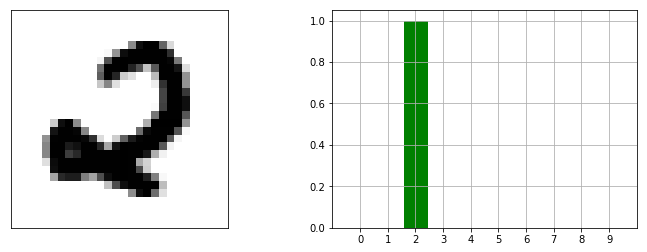

Predicted answer: 2


In [13]:
idx = random.randint(0, test_images.shape[0])
sample = test_images[idx,:]
test_digit(sample)

In [14]:
print('True Answer: {}'.format(test_labels[idx]))

True Answer: 2


## Run inference on our example

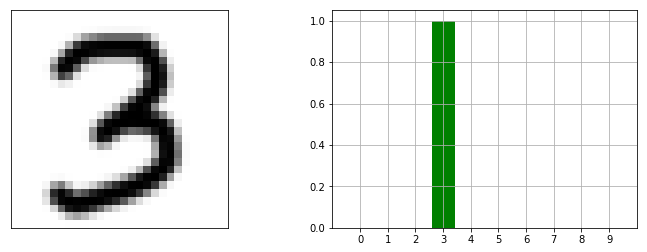

Predicted answer: 3


In [15]:
import imageio
from skimage.transform import resize

def load_and_prepare_image(fpath):
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (28, 28), order=3, mode='reflect', anti_aliasing=True)
    img = (1. - img).astype(np.float32)
    img = np.mean(img, axis=2)
    img = np.reshape(img, (28, 28, 1))
    return img

img = load_and_prepare_image('digit.png')
test_digit(img)

## QR code link to this demo

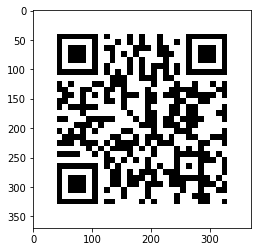

In [16]:
GITHUB_URL = 'https://github.com/dkorobchenko-nv/dl-demo'

import qrcode
fig = plt.figure(figsize=(4, 4))
_=plt.imshow(qrcode.make(GITHUB_URL))